## Finding Magnetic Nulls in MMS and Cluster Data

This notebook will show how to use PySPEDAS to locate and characterize magnetic null points, using data from missions such as MMS or Cluster, which can take simultaneous magnetic field measurements at four or more points in space in a roughly tetrahedral arrangement.   The method used is First Order Taylor Expansion (FOTE), which takes four point field measurements and positions, and uses a tetrahedral interpolation method to estimate the field vector and field gradients at the barycenter of the tetrahedron.  This makes it possible to solve for the position of a magnetic null point, as long as the field measurements vary between the four spacecraft.

First, we'll need to ensure that a PySPEDAS version supporting magnetic null finding is installed.  (You can skip this step if you're working in an environment with up-to-date installations of PySPEDAS and SpacePy. It's mainly here to set up a working environment for Google Colab users.)

In [16]:
!pip install "pyspedas>=1.5.4"
# The SpacePy package is required for the MMS qcotrans routine, which will be used in this notebook
!pip install spacepy


[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
  Using cached spacepy-0.4.1-cp39-cp39-macosx_13_0_arm64.whl

[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


Let's start with a Cluster example from August 17, 2003.  This event is used as an example in Fu et al [2015], available online here:
 
https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2015JA021082
  
We will need to load magnetic field measurements and ephemeris positions from all four probes.  Both data sets can be found in the 'CP_FGM_FULL' datatype.  We will load the data directly from the Cluster Science Archive, using the load routine `pyspedas.cluster.load_csa()`

In [4]:
# Here are some imports we'll need below.
import pyspedas
import pytplot

# We'll import a few pytplot routines, to simplify things below
from pytplot import timespan, highlight, time_double, options, tplot, tnames


In [5]:
data = pyspedas.cluster.load_csa(probes=['C1','C2','C3','C4'],trange=['2003-08-17/16:40', '2003-08-17/16:45'],datatypes='CP_FGM_FULL', time_clip=True)
pytplot.tplot_names()


19-Jan-24 11:18:05: Downloading Cluster data, please wait....
19-Jan-24 11:18:41: Download complete.


0 : B_vec_xyz_gse__C1_CP_FGM_FULL
1 : B_mag__C1_CP_FGM_FULL
2 : sc_pos_xyz_gse__C1_CP_FGM_FULL
3 : B_vec_xyz_gse__C2_CP_FGM_FULL
4 : B_mag__C2_CP_FGM_FULL
5 : sc_pos_xyz_gse__C2_CP_FGM_FULL
6 : B_vec_xyz_gse__C3_CP_FGM_FULL
7 : B_mag__C3_CP_FGM_FULL
8 : sc_pos_xyz_gse__C3_CP_FGM_FULL
9 : B_vec_xyz_gse__C4_CP_FGM_FULL
10 : B_mag__C4_CP_FGM_FULL
11 : sc_pos_xyz_gse__C4_CP_FGM_FULL


['B_vec_xyz_gse__C1_CP_FGM_FULL',
 'B_mag__C1_CP_FGM_FULL',
 'sc_pos_xyz_gse__C1_CP_FGM_FULL',
 'B_vec_xyz_gse__C2_CP_FGM_FULL',
 'B_mag__C2_CP_FGM_FULL',
 'sc_pos_xyz_gse__C2_CP_FGM_FULL',
 'B_vec_xyz_gse__C3_CP_FGM_FULL',
 'B_mag__C3_CP_FGM_FULL',
 'sc_pos_xyz_gse__C3_CP_FGM_FULL',
 'B_vec_xyz_gse__C4_CP_FGM_FULL',
 'B_mag__C4_CP_FGM_FULL',
 'sc_pos_xyz_gse__C4_CP_FGM_FULL']

Now we set up two lists of tplot variables, representing the field measurements and spacecraft positions.

In [6]:

fields = ['B_vec_xyz_gse__C'+prb+'_CP_FGM_FULL' for prb in ['1', '2', '3', '4']]
positions = ['sc_pos_xyz_gse__C'+prb+'_CP_FGM_FULL' for prb in ['1', '2', '3', '4']]

print(fields)
print(positions)

['B_vec_xyz_gse__C1_CP_FGM_FULL', 'B_vec_xyz_gse__C2_CP_FGM_FULL', 'B_vec_xyz_gse__C3_CP_FGM_FULL', 'B_vec_xyz_gse__C4_CP_FGM_FULL']
['sc_pos_xyz_gse__C1_CP_FGM_FULL', 'sc_pos_xyz_gse__C2_CP_FGM_FULL', 'sc_pos_xyz_gse__C3_CP_FGM_FULL', 'sc_pos_xyz_gse__C4_CP_FGM_FULL']


Fu's paper used GSM coordinates.  We will use pyspedas.cotrans() on the field and position variables to do the conversion:

In [7]:
for f in fields:
    pyspedas.cotrans(f,coord_out='gsm')
for p in positions:
    pyspedas.cotrans(p,coord_out='gsm')
fields_gsm = tnames('B_vec_xyz_gse*gsm')
positions_gsm = tnames('sc_pos_xyz*gsm')

19-Jan-24 11:18:42: ['gse', 'gsm']
19-Jan-24 11:18:42: Running transformation: subgse2gsm
19-Jan-24 11:18:42: Output variable: B_vec_xyz_gse__C1_CP_FGM_FULL_gsm
19-Jan-24 11:18:42: ['gse', 'gsm']
19-Jan-24 11:18:42: Running transformation: subgse2gsm
19-Jan-24 11:18:42: Output variable: B_vec_xyz_gse__C2_CP_FGM_FULL_gsm
19-Jan-24 11:18:42: ['gse', 'gsm']
19-Jan-24 11:18:42: Running transformation: subgse2gsm
19-Jan-24 11:18:42: Output variable: B_vec_xyz_gse__C3_CP_FGM_FULL_gsm
19-Jan-24 11:18:42: ['gse', 'gsm']
19-Jan-24 11:18:42: Running transformation: subgse2gsm
19-Jan-24 11:18:42: Output variable: B_vec_xyz_gse__C4_CP_FGM_FULL_gsm
19-Jan-24 11:18:42: ['gse', 'gsm']
19-Jan-24 11:18:42: Running transformation: subgse2gsm
19-Jan-24 11:18:42: Output variable: sc_pos_xyz_gse__C1_CP_FGM_FULL_gsm
19-Jan-24 11:18:42: ['gse', 'gsm']
19-Jan-24 11:18:42: Running transformation: subgse2gsm
19-Jan-24 11:18:42: Output variable: sc_pos_xyz_gse__C2_CP_FGM_FULL_gsm
19-Jan-24 11:18:42: ['gse', 'gsm

Let's take a look at the magnetometer data from all four probes.

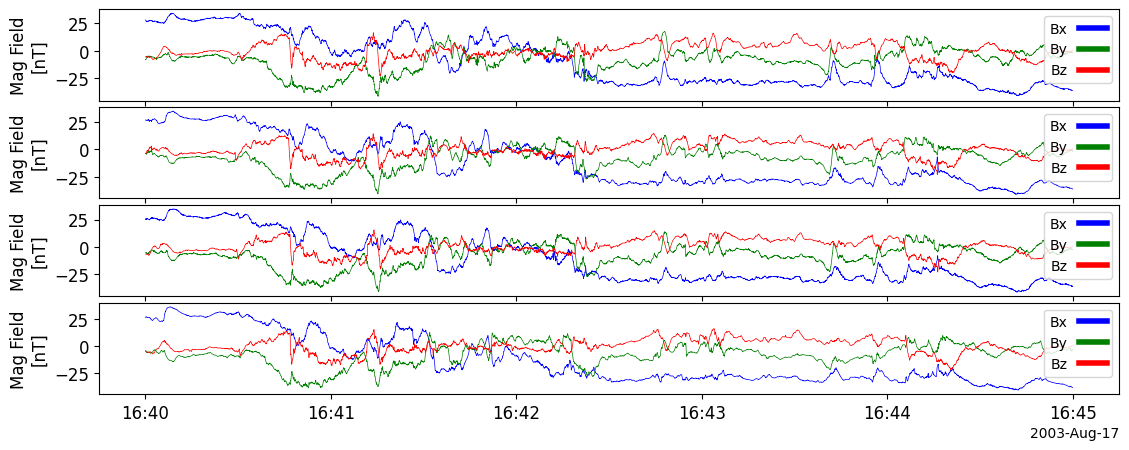

In [8]:
tplot(fields_gsm)

The time interval around 16:42 looks interesting -- all four probes are seeing field measurements near zero, with some sign changes, so there might be a magnetic null in or near the tetrahedron.

Now we call the FOTE magnetic null finder. In addition to the two sets of tplot variables, it takes some smoothing parameters to apply to the field data.  In this call, we will disable smoothing. The output will be a list of tplot variables describing the nulls found.

In [9]:
null_vars = pyspedas.find_magnetic_nulls_fote(fields=fields_gsm, positions=positions_gsm, smooth_fields=False)
print(null_vars)


19-Jan-24 11:18:43: tinterpol (linear) was applied to: pos1_i
19-Jan-24 11:18:43: tinterpol (linear) was applied to: pos2_i
19-Jan-24 11:18:43: tinterpol (linear) was applied to: pos3_i
19-Jan-24 11:18:43: tinterpol (linear) was applied to: pos4_i
19-Jan-24 11:18:43: tinterpol (linear) was applied to: b1_i
19-Jan-24 11:18:43: tinterpol (linear) was applied to: b2_i
19-Jan-24 11:18:43: tinterpol (linear) was applied to: b3_i
19-Jan-24 11:18:43: tinterpol (linear) was applied to: b4_i
19-Jan-24 11:18:44: Calculations completed


['null_pos', 'null_bary_dist', 'null_bary_dist_types', 'null_sc_distances', 'null_fom', 'null_typecode', 'max_reconstruction_error']


We see that several tplot variables were produced:

* null_pos: Contains the position of any nulls found, in the same coordinate system as the s/c positions
* null_bary_dist:  Euclidean distance between the nulls and the tetrahedron barycenter
* null_bary_dist_types:  Null-barycenter distances, annotated with the topological type of any nulls found (X-type, O-type, A-type (radial), B-type (radial), A_s type (spiral), or B_s type (spiral).
* null_sc_distances:  Euclidean distance between the null, and each of the four spacecraft
* null_fom:  The "eta" and "xi" figures of merit, representing the confidence in the null location and null type detection.  Lower is better, with < 0.4 denoting fairly believable results
* null_typecode:  An integer representing the type of the nulls found
* max_reconstruction_error:  The maximum difference, among the four s/c, of the difference between the observed field vectors, and field vectors reconstructed from the interpolated values and estimated gradients.  These should be very close to zero.

Let's plot a few of these quantities.

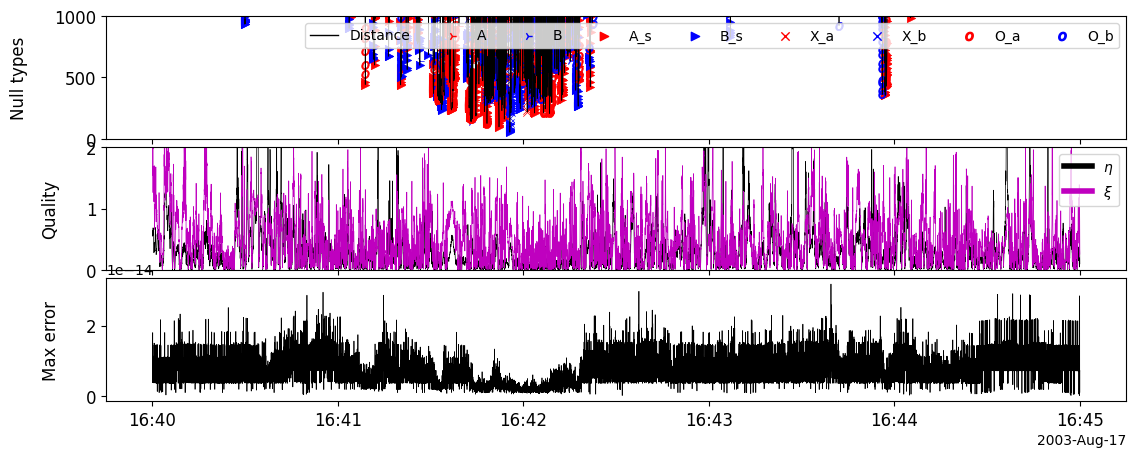

In [10]:
tplot(['null_bary_dist_types','null_fom','max_reconstruction_error'])

The reconstruction error is down around 2e-14, close to the double precision floating point resolution, as expected. Let's take a closer look at a two-second time interval, 16:41:55 to 16:41:57.  We'll also reduce the yrange of the null_fom plot to be a little easier to interpret.

19-Jan-24 11:18:47: No data found in the time range: null_type5
19-Jan-24 11:18:47: No data found in the time range: null_type9


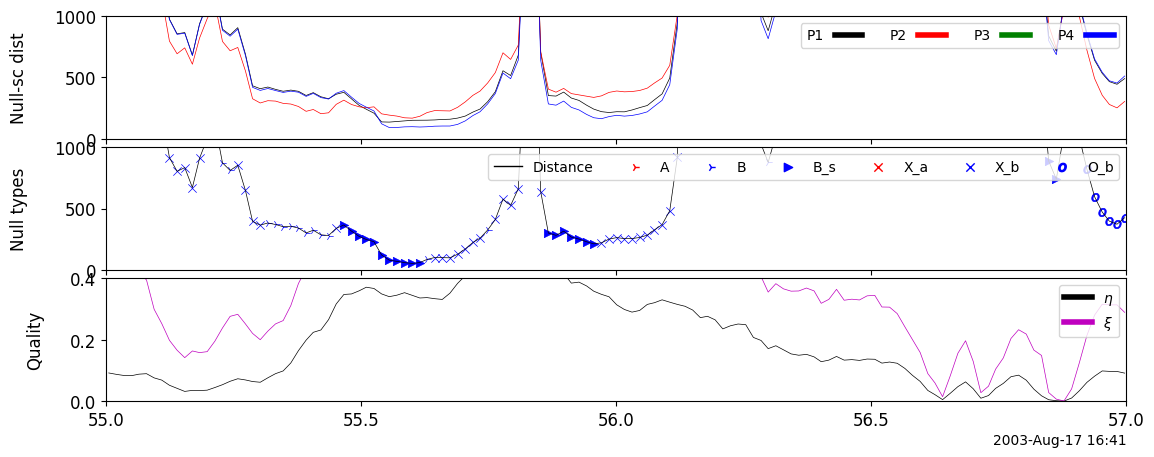

In [11]:
options('null_fom','yrange',[0.0,0.4])
timespan('2003-08-17/16:41:55.0',2.0,'seconds')
tplot(['null_sc_distances','null_bary_dist_types','null_fom'])

It appears that a null passed very near or within the Cluster tetrahedron around 16:41:55.6.   Initially, it was classified (using the three complex eigenvalues of the estimated Jacobian matrix) as a B-type radial null, as shown in the second panel.  The type then appears to switch to B_s type (spiral), then simplify to a 2-D X-type null.  However, the xi values have risen above 0.4 when the null type classification changes, so the B_s and X classifications may be artifacts.

Now let's look at another example, using MMS data.  This event, on 2017-07-26, is studied in Zhang et al [2023], available online here:
  
https://iopscience.iop.org/article/10.3847/1538-4357/acdacf

We'll start by loading some relevant data: ephemeris data for the probe positions, FGM data for the magnetic field measurements, and FPI data for particle moments and energy spectra.

In [12]:
state_vars = pyspedas.mms.mms_load_state(trange=['2017-07-26/07:00','2017-07-26/08:00'],probe=['1','2','3','4'])

# For FGM, we'll use the survey data for the overview plot, and burst data for the
# null analysis.

fgm_vars = pyspedas.mms.fgm(trange=['2017-07-26/07:00','2017-07-26/08:00'],probe=['1','2','3','4'],data_rate='brst',time_clip=True)
fgm_vars = pyspedas.mms.fgm(trange=['2017-07-26/07:00','2017-07-26/08:00'],probe=['1'],data_rate='srvy',time_clip=True)

fpi_vars = pyspedas.mms.mms_load_fpi(trange=['2017-07-26/07:00','2017-07-26/08:00'],probe=['1','2','3','4'],time_clip=True,data_rate='fast')

# Reset time limits from previous examples
timespan('2017-07-26/08:00',60.0,'minutes')


19-Jan-24 11:18:49: Downloading MMS1_DEFEPH_2017207_2017208.V01 to pydata/ancillary/mms1/defeph
19-Jan-24 11:18:50: Downloading MMS1_DEFEPH_2017206_2017207.V01 to pydata/ancillary/mms1/defeph
19-Jan-24 11:18:51: Loading pydata/ancillary/mms1/defeph/MMS1_DEFEPH_2017206_2017207.V01
19-Jan-24 11:18:51: Loading pydata/ancillary/mms1/defeph/MMS1_DEFEPH_2017207_2017208.V01
19-Jan-24 11:18:51: Downloading MMS2_DEFEPH_2017207_2017208.V01 to pydata/ancillary/mms2/defeph
19-Jan-24 11:18:52: Downloading MMS2_DEFEPH_2017206_2017207.V01 to pydata/ancillary/mms2/defeph
19-Jan-24 11:18:53: Loading pydata/ancillary/mms2/defeph/MMS2_DEFEPH_2017206_2017207.V01
19-Jan-24 11:18:53: Loading pydata/ancillary/mms2/defeph/MMS2_DEFEPH_2017207_2017208.V01
19-Jan-24 11:18:54: Downloading MMS3_DEFEPH_2017207_2017208.V01 to pydata/ancillary/mms3/defeph
19-Jan-24 11:18:55: Downloading MMS3_DEFEPH_2017206_2017207.V01 to pydata/ancillary/mms3/defeph
19-Jan-24 11:18:55: Loading pydata/ancillary/mms3/defeph/MMS3_DEFEPH

The MMS ephemeris data is in ECI coordinates.  We'll be working in GSE, so we need to transform the loaded variables.

In [18]:
# To use the MMS qcotrans routine, the quaternions representing the transforms must be
# loaded from the MEC dataset.
pyspedas.mms.mec(trange=['2017-07-26/07:00','2017-07-26/08:00'], probe=['1','2','3','4'])

for i in ('1','2','3','4'): pyspedas.mms.mms_qcotrans('mms'+i+'_defeph_pos','mms'+i+'_defeph_pos_gse',in_coord='eci',out_coord='gse')

19-Jan-24 11:38:50: Loading pydata/mms1/mec/srvy/l2/epht89q/2017/07/mms1_mec_srvy_l2_epht89q_20170726_v2.0.1.cdf
19-Jan-24 11:38:50: Loading pydata/mms2/mec/srvy/l2/epht89q/2017/07/mms2_mec_srvy_l2_epht89q_20170726_v2.0.1.cdf
19-Jan-24 11:38:50: Loading pydata/mms3/mec/srvy/l2/epht89q/2017/07/mms3_mec_srvy_l2_epht89q_20170726_v2.0.1.cdf
19-Jan-24 11:38:50: Loading pydata/mms4/mec/srvy/l2/epht89q/2017/07/mms4_mec_srvy_l2_epht89q_20170726_v2.0.1.cdf
19-Jan-24 11:38:51: Loaded variables:
19-Jan-24 11:38:51: mms1_mec_dipole_tilt
19-Jan-24 11:38:51: mms1_mec_gmst
19-Jan-24 11:38:51: mms1_mec_mlat
19-Jan-24 11:38:51: mms1_mec_mlt
19-Jan-24 11:38:51: mms1_mec_l_dipole
19-Jan-24 11:38:51: mms1_mec_quat_eci_to_bcs
19-Jan-24 11:38:51: mms1_mec_quat_eci_to_dbcs
19-Jan-24 11:38:51: mms1_mec_quat_eci_to_dmpa
19-Jan-24 11:38:51: mms1_mec_quat_eci_to_smpa
19-Jan-24 11:38:51: mms1_mec_quat_eci_to_dsl
19-Jan-24 11:38:51: mms1_mec_quat_eci_to_ssl
19-Jan-24 11:38:51: mms1_mec_L_vec
19-Jan-24 11:38:51: mm

Figure 1 in Zhang's study shows the magnetic field, the ion velocity, electron density, and ion and electron energy spectra. We will make a few adjustments to the time range and plot options, to more closely match the published figure.

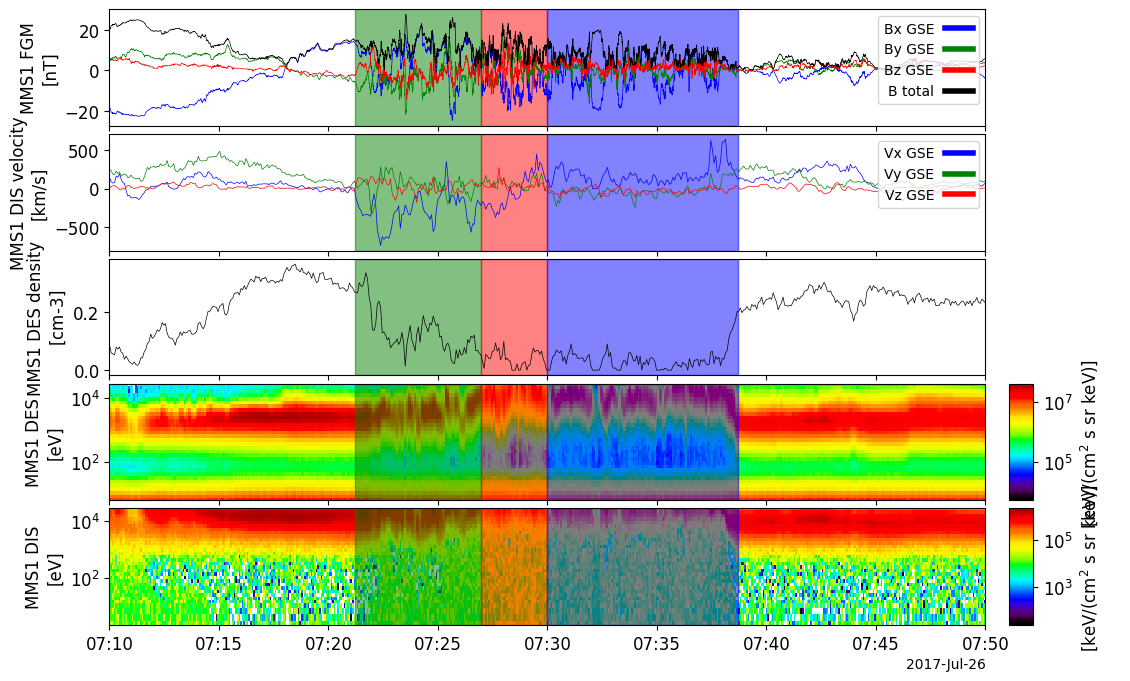

In [23]:

timespan('2017-07-26/07:10',40,'minutes')
# Zhang uses a linear scale for the density
options('mms1_des_numberdensity_fast','ylog',False)
fig1_vars=['mms1_fgm_b_gse_srvy_l2','mms1_dis_bulkv_gse_fast','mms1_des_numberdensity_fast','mms1_des_energyspectr_omni_fast','mms1_dis_energyspectr_omni_fast']
# We want to highlight some time intervals, to be explained below
trange_tailward = [time_double('2017-07-26/07:21:13'),time_double('2017-07-26/07:26:57')]
trange_reversal = [time_double('2017-07-26/07:26:57'),time_double('2017-07-26/07:30:00')]
trange_earthward = [time_double('2017-07-26/07:30:00'),time_double('2017-07-26/07:38:42')]
highlight(fig1_vars,trange_tailward,color='g',fill=True,alpha=0.2)
highlight(fig1_vars,trange_reversal,color='r',fill=True,alpha=0.2)
highlight(fig1_vars,trange_earthward,color='b',fill=True,alpha=0.2)
tplot(fig1_vars)

Zhang mentions several features evident in the above figure: 

> From 07:21:13–07:38:42 UT, strong, and turbulent fluctuations in the magnetic field   appeared (Figure 1(a)), and the high irregularity in the behavior of the magnetic field could suggest chaotic magnetic field lines. Concurrently, electron and ion fluxes showed characteristic energies with significant variations (Figures 1(d) and (e)). The density was depleted (Figure 1(c)). The ion flow velocity (see Figure 1(b)) reverses from tailward to earthward, suggesting an ongoing magnetic reconnection process. 

> [...] we divide the whole turbulence region (07:21:13–07:38:42 UT) into three areas according to ion flow velocity (Figure 1(b)): tailward flow region (07:21:13–07:26:57 UT); reversal flow region (07:26:57–07:30:00 UT); and earthward flow region (07:30:00–07:38:42 UT)

The tailward, reversal, and earthward intervals are highlighted in green, red, and blue in the plot.

Now we will find the magnetic nulls during this event, and examine the field toplology for a couple of them:

19-Jan-24 11:39:41: tsmooth was applied to: mms1_fgm_b_gse_brst_l2_sm
19-Jan-24 11:39:45: tsmooth was applied to: mms2_fgm_b_gse_brst_l2_sm
19-Jan-24 11:39:49: tsmooth was applied to: mms3_fgm_b_gse_brst_l2_sm
19-Jan-24 11:39:53: tsmooth was applied to: mms4_fgm_b_gse_brst_l2_sm
19-Jan-24 11:39:53: tinterpol (linear) was applied to: pos1_i
19-Jan-24 11:39:54: tinterpol (linear) was applied to: pos2_i
19-Jan-24 11:39:54: tinterpol (linear) was applied to: pos3_i
19-Jan-24 11:39:54: tinterpol (linear) was applied to: pos4_i
19-Jan-24 11:39:54: tinterpol (linear) was applied to: b1_i
19-Jan-24 11:39:54: tinterpol (linear) was applied to: b2_i
19-Jan-24 11:39:54: tinterpol (linear) was applied to: b3_i
19-Jan-24 11:39:54: tinterpol (linear) was applied to: b4_i
19-Jan-24 11:40:11: Calculations completed


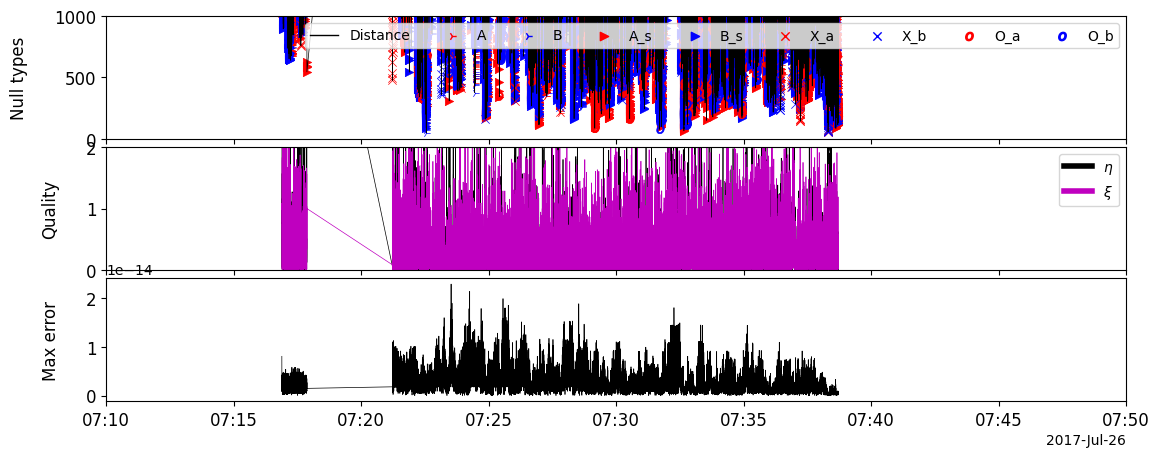

In [20]:
mms_positions = ['mms1_defeph_pos_gse','mms2_defeph_pos_gse','mms3_defeph_pos_gse','mms4_defeph_pos_gse']
mms_fields = ['mms1_fgm_b_gse_brst_l2','mms2_fgm_b_gse_brst_l2','mms3_fgm_b_gse_brst_l2','mms4_fgm_b_gse_brst_l2']

null_vars = pyspedas.find_magnetic_nulls_fote(fields=mms_fields, positions=mms_positions, smooth_fields=True)
tplot(['null_bary_dist_types','null_fom','max_reconstruction_error'])


First, we'll look at a short time interval starting at 07:23:55.30:

19-Jan-24 11:40:42: No data found in the time range: null_type3
19-Jan-24 11:40:42: No data found in the time range: null_type4
19-Jan-24 11:40:42: No data found in the time range: null_type5
19-Jan-24 11:40:42: No data found in the time range: null_type7
19-Jan-24 11:40:42: No data found in the time range: null_type8
19-Jan-24 11:40:42: No data found in the time range: null_type9
19-Jan-24 11:40:42: No data found in the time range: null_type10


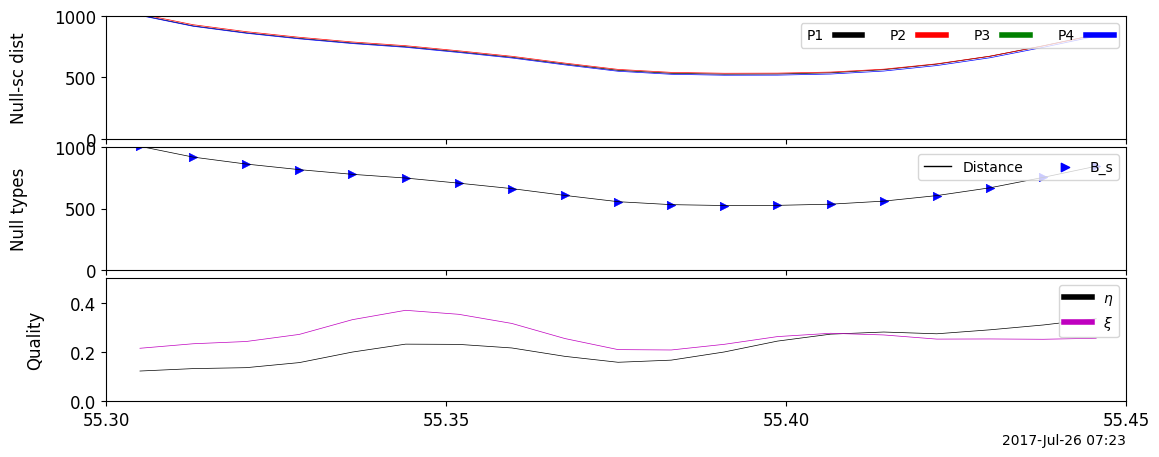

In [21]:
timespan('2017-07-26/07:23:55.30',0.15,'seconds')
options('null_fom','yrange',[0.0,0.5])
tplot(['null_sc_distances','null_bary_dist_types','null_fom'])

The PySPEDAS analysis appears to agree quite well with Zhang's corresponding Figure 5. Both figures agree that the null had a Bs topological type, and the eta and xi values indicate mostly reliable position and topology determinations.

Now we'll look at the time interval 07:31:47.30 - 07:31:47.60:

19-Jan-24 11:41:07: No data found in the time range: null_type6
19-Jan-24 11:41:07: No data found in the time range: null_type7
19-Jan-24 11:41:07: No data found in the time range: null_type8
19-Jan-24 11:41:07: No data found in the time range: null_type9
19-Jan-24 11:41:07: No data found in the time range: null_type10


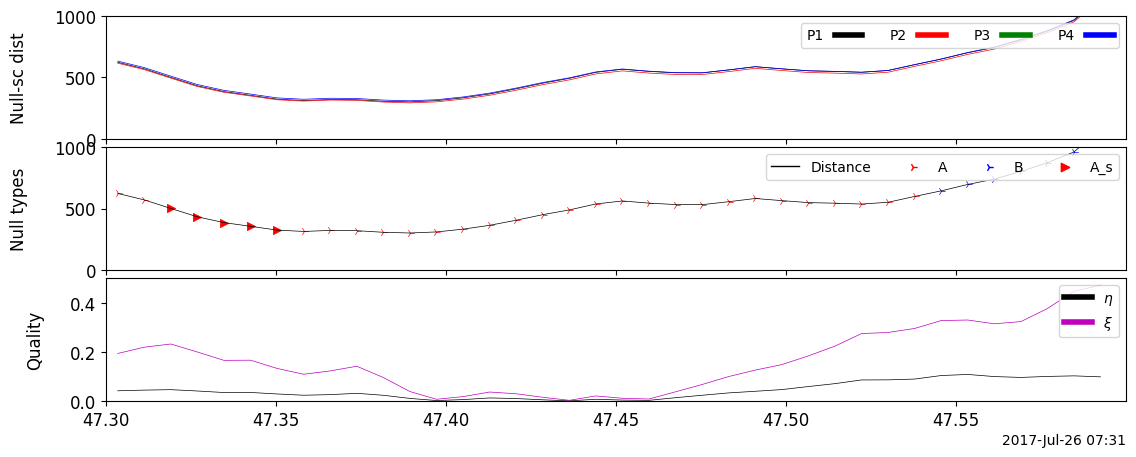

In [22]:
timespan('2017-07-26/07:31:47.30',0.30,'seconds')
tplot(['null_sc_distances','null_bary_dist_types','null_fom'])

In this figure, PySPEDAS seems to place the null farther away from the tetrahedron than Zhang's analysis. (~500 km vs. ~50 km). Differences between the two figures may be due to different calibration, smoothing, interpolation, or other preprocessing steps performed in each analysis.  Both figures agree that the nulls are classified as mostly type A. Zhang has some of the nulls simplifying to type X, however it appears their simplification criterion is slightly different from that used by Fu and PySPEDAS.

References:

Fu, H. S., A. Vaivads, Y. V. Khotyaintsev, V. Olshevsky, M. André, J. B. Cao, S. Y. Huang, A. Retinò, and G. Lapenta (2015), How to find magnetic nulls and reconstruct field topology with MMS data?. J. Geophys. Res. Space Physics, 120, 3758–3782. doi: 10.1002/2015JA021082.

W. Z. Zhang, H. S. Fu1J. B. Cao1, Z. Wang, and Y. Y. Liu (2023), Properties of the Turbulence and Topology in a Turbulent Magnetic Reconnection, ApJ, Volume 953, Number 1.
 doi: 10.3847/1538-4357/acdacf
